# Policy Gradient method

In [7]:
import math
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

#========================================================================================

class AgentModel(nn.Module):
    """ Neural network for pi(s,a) """
    def __init__(self, sizes, hidden=nn.ReLU, output=nn.Identity):
        super(AgentModel, self).__init__()        
        layers = []        
        for i in range(len(sizes)-1):            
            activation = hidden if i < len(sizes)-2 else output
            layers += [ nn.Linear(sizes[i], sizes[i+1]), activation() ]        
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)        
    

class GradientPolicy:
    def __init__(self, env):
        self.env  = env                         # environment we work with
        self.low  = env.observation_space.low   # minimum observation values
        self.high = env.observation_space.high  # maximum observation values
        self.nA   =  self.env.action_space.n    # number of discrete actions
        self.nS   =  self.env.observation_space.shape[0] # number of state components
        self.action_space = np.arange(env.action_space.n)    

        self.params = {             # default parameters
            'method'   : "GradPolicy",# kind of the method (GradPolicy)     
            'gamma'    : 0.99,      # discount factor
            'eps1'     : 1.0,       # initial value epsilon
            'eps2'     : 0.001,     # final value   epsilon
            'decays'   : 1000,      # number of episodes to decay eps1 - > eps2
            'update'   : 10,        # target model update rate (in frames = time steps)         
            'batch'    : 100,       # batch size for training
            'capacity' : 100000,    # memory size
            'rewrite'  : 1.0,       # rewrite memory (if < 1 - sorted)
            'hiddens'  : [256,128], # hidden layers
            'scale'    : True,      # scale or not observe to [-1...1]
            'loss'     : 'huber',     # loss function (mse, huber)
            'optimizer': 'sgd',     # optimizer (sgd, adam)
            'lm'       : 0.001,     # learning rate           
        }
        self.last_loss = 0.         # last loss

        print("low :   ", self.low)
        print("high:   ", self.high)        
                
    #------------------------------------------------------------------------------------

    def init(self):
        """ Create a neural network and optimizer """

        #self.device = "cpu"
        self.device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")        
        print("device:", self.device)

        self.model  = AgentModel([self.nS]+self.params['hiddens']+[self.nA]).to(self.device)      # current Q        

        self.best_model  = AgentModel([self.nS]+self.params['hiddens']+[self.nA]).to(self.device) # best net
        self.best_reward = -100000                                                           # best reward

        if   self.params['loss'] == 'mse':
             self.loss  = nn.MSELoss()
        elif self.params['loss'] == 'huber':
             self.loss = nn.HuberLoss()
        else:
            print("ERROR: Unknown loss function!!!")
        
        if   self.params['optimizer'] == 'sgd':
             self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.params['lm'], momentum=0.8)
        elif self.params['optimizer'] == 'adam':
             self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['lm'])
        else:
            print("ERROR: Unknown optimizer!!!")        
        
        self.epsilon     = self.params['eps1']        # start value in epsilon greedy strategy
        self.decay_rate  = math.exp(math.log(self.params['eps2']/self.params['eps1'])/self.params['decays'])

        print(f"decay_rate: {self.decay_rate:.4f}")
        print(self.model)                    
        
    #------------------------------------------------------------------------------------

    def scale(self, obs):
        """ to [-1...1] """
        if self.params['scale']:
            return -1. + 2.*(obs - self.low)/(self.high-self.low)
        else:
            return obs
        
    #------------------------------------------------------------------------------------

    def policy(self, state):
        """ Return action according to epsilon greedy strategy """
        if np.random.random() < self.epsilon:            
            return np.random.randint(self.nA)    # random action            

        x = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            y = self.model(x).detach().to('cpu')
        probs = torch.softmax(y, 0).numpy()      
        return np.random.choice(self.action_space, p=probs)         # action by probability
    
    #------------------------------------------------------------------------------------
    
    def create_memory(self, capacity):                
        """ Сreate a memory for states, actions and rewards """
        self.capacity = capacity 
        self.count    = 0                
        self.memo_S   = [None]*capacity 
        self.memo_A   = [None]*capacity
        self.memo_R   = [None]*capacity
    
    #------------------------------------------------------------------------------------
    
    def append_memory(self, S, A, R):
        """ Add to memory data lists """
        for i in range(len(S)):
            index = self.count % self.capacity
            self.memo_S[index] = S[i]
            self.memo_A[index] = A[i]
            self.memo_R[index] = R[i]
            self.count += 1

    #------------------------------------------------------------------------------------
    
    def discount_rewards(self, rewards):
        """ """
        gamma = self.params['gamma']
        
        #r = np.array( [gamma**i * rewards[i] for i in range(len(rewards))] )    
        #r = r[: : -1].cumsum()[ : : -1]                      # срез:  [beg : end : steps]
        #return r - r.mean()    
        
        if True:
            res = np.zeros( (len(rewards),) )
            cum = 0
            for t in range(0, len(rewards), -1):
                cum = rewards[t] + cum*gamma
                res[t] = cum             
            #res -= np.mean(rewards)
            return res
    
        #return [np.sum(rewards)]*len(rewards)
                
    #------------------------------------------------------------------------------------
    
    def run_episode(self, ticks):
        """ Complete one episode """
        states, actions, rewards = [], [], []
        state, tot_rew = self.env.reset(), 0
        for t in range(1, ticks+1):                
            action = self.policy(state)
            
            actions.append( action )
            states. append( state.tolist() )                
            
            state, rew, done, _ = self.env.step(action)               
            tot_rew += rew
            rewards.append(rew+10*abs(state[1]))                
                
            if done:        
                break                                      # эпизод окончен                               
        
        self.append_memory( states, actions, self.discount_rewards(rewards) )
        
        return tot_rew, t 
            
    #------------------------------------------------------------------------------------
    
    def learn(self, episodes=1000, stat1 = 10, stat2 = 100, plots = 1000, rews_range = [-1000, 1000]):                                
        self.create_memory(self.params['capacity'])
        self.history = []                        
        rews, lens, beg  = [], [], time.process_time()
        for episode in range(1, episodes+1):                       
            rew, t = self.run_episode( self.params['ticks'] )
            rews.append(rew)
            lens.append(t)

            self.epsilon *= self.decay_rate                # epsilon-decay
            if self.epsilon < self.params['eps2']:
                self.epsilon = 0.                
            
            if self.count >= self.capacity:
                self.learn_model()

            if episode % stat1 == 0:
                self.history.append([episode, np.mean(rews[-stat1:]), np.mean(rews[-stat2:])])      
                                
            if  episode % stat2 == 0:                               
                mean, std    = np.mean(rews[-stat2:]), np.std(rews[-stat2:])    
                lensM, lensS = np.mean(lens[-stat2:]), np.std(lens[-stat2:])                    
                if mean > self.best_reward:
                    self.best_reward = mean
                    self.best_model.load_state_dict( self.model.state_dict() )                     
                
                print(f"{episode:6d} rew:{mean:7.1f} ± {std/stat2**0.5:3.1f}, best:{self.best_reward:7.2f}, ticks:{lensM:3.0f}, eps:{self.epsilon:.3f},  loss:{self.last_loss:7.3f}, {(time.process_time() - beg):3.0f}s")
                beg = time.process_time()
                
            if  episode % plots == 0:                   
                self.plot(f"{self.params['env']}  Episode: {episode}  best: {self.best_reward:7.1f}", rews_range)                        
    
    #------------------------------------------------------------------------------------
    
    def learn_model(self):
        """ Model Training """
        num = min(self.capacity, self.count)
        if num == 0:
            return        
       
        S = torch.FloatTensor(self.memo_S[:num]).to(self.device)
        W = torch.FloatTensor(self.memo_R[:num]).to(self.device)                    
        A = torch.LongTensor (self.memo_A[:num]).to(self.device)              # Actions are used as indices, must be LongTensor        
        
        batch = min(num, self.params['batch'])
        for epoch in range(1, self.params['epochs']+1):
            idx = torch.randperm( len(S) ).to(self.device)                         # перемешанный список индексов
            S, W, A = S[idx], W[idx], A[idx]
        
            tot_L,  num_B = 0, int( len(S)/batch ) 
            for i in range(0, num_B*batch, batch):          
                sb, wb, ab = S[i: i+batch], W[i: i+batch], A[i: i+batch]                         
            
                probs = torch.softmax( self.model(sb), 1 )
                logprob = (probs+1.e-5).log()                      # логарифм вероятностей
                logprob = torch.gather(logprob, 1, ab.view(-1,1)).squeeze()            
                loss = -(wb * logprob).mean()                       # Calculate loss                    

                self.optimizer.zero_grad()
                loss.backward()                                     # Calculate gradients                    
                self.optimizer.step()                               # Apply gradients

                tot_L += loss.item()                
                
        self.last_loss = tot_L / num_B

    #------------------------------------------------------------------------------------
    
    def plot(self, text, rews_range):
        """ Plot histogram for states and actions """        
        num = min(self.count, self.capacity)
        if num == 0:
            return
                
        hist_S, bins_S = np.histogram(self.memo_S, bins=np.linspace(0, math.sqrt(self.nS), 101), density=True)        
        hist_A, bins_A = np.histogram(self.memo_A, bins=np.linspace(-0.5, self.nA-0.5, self.nA+1), density=True)    

        fig, ax = plt.subplots(1, 3, figsize=(16,6), gridspec_kw={'width_ratios': [2, 1, 5]})        
        plt.suptitle(text, fontsize=18)
                                
        ax[0].set_xlim(min(bins_S), max(bins_S))    # histogram for S1
        ax[0].grid(axis='x', alpha=0.75); ax[0].grid(axis='y', alpha=0.75)
        ax[0].set_xlabel('|s1|', fontsize=16)
        bins = [ (bins_S[i]+bins_S[i+1])/2 for i in range(len(bins_S)-1)]
        ax[0].bar(bins, hist_S, width=0.5, color='blue')
                        
        ax[1].set_xlim(min(bins_A), max(bins_A))    # histogram for A
        ax[1].grid(axis='x', alpha=0.75); ax[1].grid(axis='y', alpha=0.75)
        ax[1].set_xlabel('actions', fontsize=16)
        ax[1].set_xticks(np.arange(self.nA));
        bins = [ (bins_A[i]+bins_A[i+1])/2 for i in range(len(bins_A)-1)]        
        ax[1].bar(bins, hist_A, width=0.5, color='blue')

        history = np.array(self.history)            # loss history
        ax[2].plot(history[:,0], history[:,1], linewidth=1)
        ax[2].plot(history[:,0], history[:,2], linewidth=2)
        ax[2].set_ylim(rews_range[0], rews_range[1]);
        ax[2].set_xlabel('episode', fontsize=16)        
        ax[2].grid(axis='x', alpha=0.75); ax[2].grid(axis='y', alpha=0.75)
        params = [ f"{k:9s}: {v}\n" for k,v in self.params.items()]
        ax[2].text(history[0,0], rews_range[0], "".join(params), {'fontsize':12, 'fontname':'monospace'})

        plt.show()


## CartPole

low :    [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
high:    [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
device: cuda:0
decay_rate: 0.9931
AgentModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
    (3): Identity()
  )
)
   100 rew:   22.3 ± 1.3, best:  22.32, ticks: 22, eps:0.501,  loss:  0.000,   0s
   200 rew:   20.1 ± 1.1, best:  22.32, ticks: 20, eps:0.251,  loss:  0.000,   1s
   300 rew:   25.5 ± 1.7, best:  25.53, ticks: 26, eps:0.126,  loss: 21.215,   6s
   400 rew:   29.9 ± 1.9, best:  29.89, ticks: 30, eps:0.063,  loss: 27.319,   9s
   500 rew:   43.1 ± 2.6, best:  43.09, ticks: 43, eps:0.032,  loss: 36.080,  10s
   600 rew:   66.8 ± 3.8, best:  66.85, ticks: 67, eps:0.016,  loss: 55.535,  11s
   700 rew:   98.7 ± 4.5, best:  98.73, ticks: 99, eps:0.008,  loss: 78.091,  13s
   800 rew:  105.9 ± 4.6, best: 105.92, ticks:106, eps:0.00

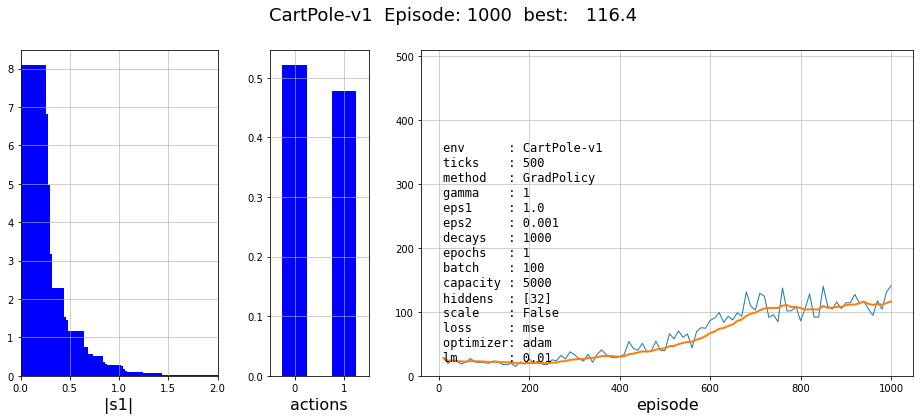

  1100 rew:  131.1 ± 4.3, best: 131.13, ticks:131, eps:0.000,  loss: 80.325,  15s
  1200 rew:  153.1 ± 6.0, best: 153.11, ticks:153, eps:0.000,  loss:104.678,  15s
  1300 rew:  206.1 ± 8.8, best: 206.13, ticks:206, eps:0.000,  loss:154.829,  17s
  1400 rew:  306.6 ± 12.0, best: 306.60, ticks:307, eps:0.000,  loss:171.534,  22s
  1500 rew:  239.8 ± 8.8, best: 306.60, ticks:240, eps:0.000,  loss:116.684,  19s
  1600 rew:  271.7 ± 10.7, best: 306.60, ticks:272, eps:0.000,  loss:175.455,  20s
  1700 rew:  379.4 ± 12.3, best: 379.44, ticks:379, eps:0.000,  loss:225.843,  25s
  1800 rew:  342.0 ± 13.8, best: 379.44, ticks:342, eps:0.000,  loss:172.430,  24s
  1900 rew:  375.5 ± 14.4, best: 379.44, ticks:376, eps:0.000,  loss:238.879,  25s
  2000 rew:  473.3 ± 8.5, best: 473.34, ticks:473, eps:0.000,  loss:244.703,  31s


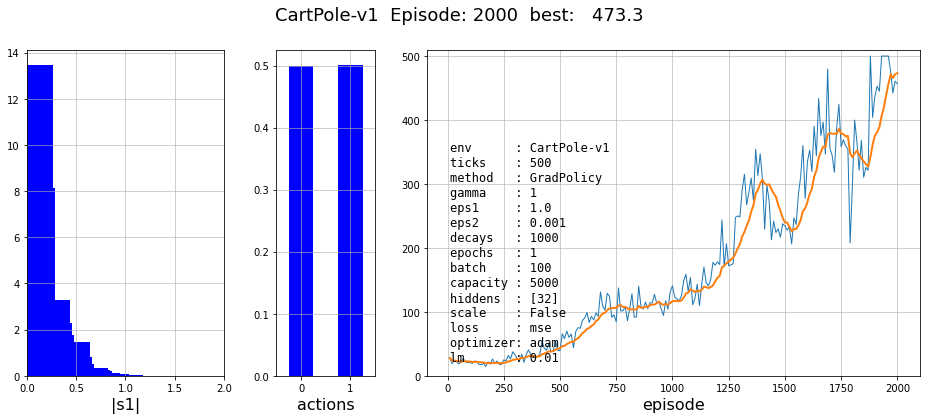

  2100 rew:  452.2 ± 9.4, best: 473.34, ticks:452, eps:0.000,  loss:225.502,  30s
  2200 rew:  440.3 ± 11.6, best: 473.34, ticks:440, eps:0.000,  loss:231.151,  29s
  2300 rew:  461.1 ± 9.6, best: 473.34, ticks:461, eps:0.000,  loss:234.518,  29s
  2400 rew:  472.1 ± 8.6, best: 473.34, ticks:472, eps:0.000,  loss:218.973,  30s
  2500 rew:  477.9 ± 8.3, best: 477.89, ticks:478, eps:0.000,  loss:227.426,  31s
  2600 rew:  494.6 ± 4.3, best: 494.63, ticks:495, eps:0.000,  loss:227.796,  32s
  2700 rew:  454.2 ± 10.2, best: 494.63, ticks:454, eps:0.000,  loss:214.343,  29s
  2800 rew:  458.1 ± 9.8, best: 494.63, ticks:458, eps:0.000,  loss:220.215,  29s
  2900 rew:  454.1 ± 9.9, best: 494.63, ticks:454, eps:0.000,  loss:222.345,  29s
  3000 rew:  474.9 ± 8.7, best: 494.63, ticks:475, eps:0.000,  loss:231.006,  31s


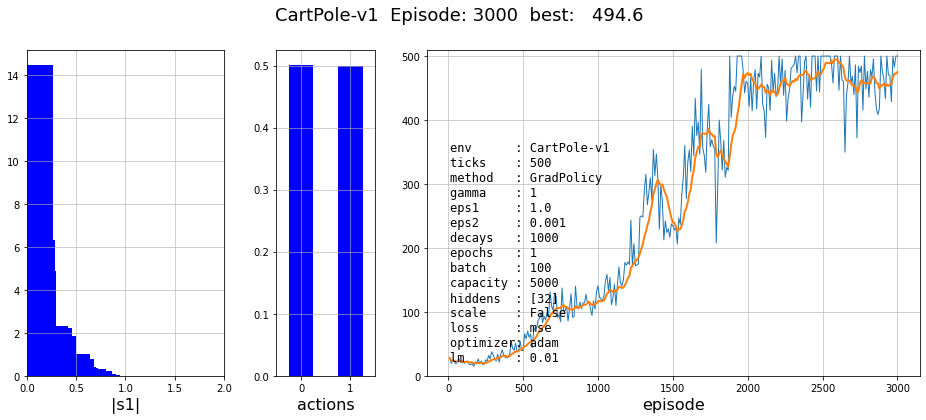

  3100 rew:  484.6 ± 7.0, best: 494.63, ticks:485, eps:0.000,  loss:222.036,  32s
  3200 rew:  441.6 ± 14.1, best: 494.63, ticks:442, eps:0.000,  loss:216.272,  29s
  3300 rew:  485.1 ± 5.1, best: 494.63, ticks:485, eps:0.000,  loss:221.995,  31s
  3400 rew:  469.9 ± 9.3, best: 494.63, ticks:470, eps:0.000,  loss:202.482,  30s
  3500 rew:  473.5 ± 8.0, best: 494.63, ticks:474, eps:0.000,  loss:206.350,  30s
  3600 rew:  482.6 ± 6.5, best: 494.63, ticks:483, eps:0.000,  loss:202.978,  30s
  3700 rew:  487.7 ± 6.7, best: 494.63, ticks:488, eps:0.000,  loss:191.236,  31s
  3800 rew:  434.6 ± 12.0, best: 494.63, ticks:435, eps:0.000,  loss:130.277,  28s
  3900 rew:  443.8 ± 9.7, best: 494.63, ticks:444, eps:0.000,  loss:186.757,  29s
  4000 rew:  493.7 ± 4.1, best: 494.63, ticks:494, eps:0.000,  loss:198.509,  31s


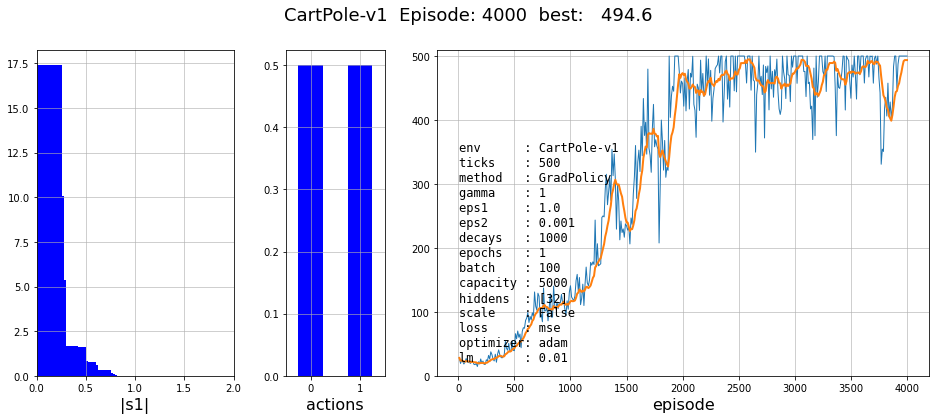

  4100 rew:  486.1 ± 6.1, best: 494.63, ticks:486, eps:0.000,  loss:212.934,  32s
  4200 rew:  492.9 ± 5.1, best: 494.63, ticks:493, eps:0.000,  loss:202.937,  32s
  4300 rew:  500.0 ± 0.0, best: 500.00, ticks:500, eps:0.000,  loss:191.463,  32s
  4400 rew:  500.0 ± 0.0, best: 500.00, ticks:500, eps:0.000,  loss:184.992,  31s
  4500 rew:  497.1 ± 1.3, best: 500.00, ticks:497, eps:0.000,  loss:183.410,  32s
  4600 rew:  492.9 ± 4.3, best: 500.00, ticks:493, eps:0.000,  loss:180.599,  31s
  4700 rew:  469.2 ± 6.3, best: 500.00, ticks:469, eps:0.000,  loss:154.971,  30s
  4800 rew:  456.6 ± 9.3, best: 500.00, ticks:457, eps:0.000,  loss:138.246,  29s
  4900 rew:  427.2 ± 11.1, best: 500.00, ticks:427, eps:0.000,  loss:153.708,  28s
  5000 rew:  446.7 ± 10.5, best: 500.00, ticks:447, eps:0.000,  loss:171.299,  29s


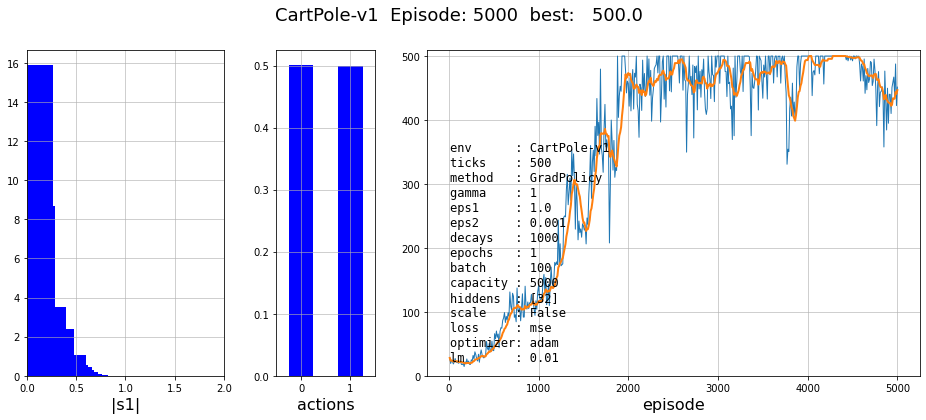

In [75]:
env_name = "CartPole-v1"    # (nS=4, nA=2)
ml = GradientPolicy( gym.make(env_name) )

ml.params = {
    'env'      : env_name,
    'ticks'    : 500,      
    'method'   : "GradPolicy",# kind of the method (GradPolicy)     
    'gamma'    : 1,           # discount factor
    'eps1'     : 1.0,         # initial value epsilon
    'eps2'     : 0.001,       # final value   epsilon
    'decays'   : 1000,        # number of episodes to decay eps1 - > eps2   
    'epochs'   : 1,
    'batch'    : 100,         # batch size for training
    'capacity' : 5000,        # memory size    
    'hiddens'  : [32],         # hidden layers
    'scale'    : False,       # scale or not observe to [-1...1]
    'loss'     : 'mse',       # loss function (mse, huber)
    'optimizer': 'adam',      # optimizer (sgd, adam)
    'lm'       : 0.01,        # learning rate           
}

ml.init()
ml.learn(episodes=5000,  rews_range = [0, 510])

## MountainCar-v0

low :    [-1.2  -0.07]
high:    [0.6  0.07]
device: cuda:0
decay_rate: 0.9931
AgentModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
    (5): Identity()
  )
)
   100 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.501,  loss:  0.000,   8s
   200 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.251,  loss:  0.000,  14s
   300 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.126,  loss:  0.000,  17s
   400 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.063,  loss:  0.000,  17s
   500 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.032,  loss:  0.000,  17s
   600 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.016,  loss:  0.000,  17s
   700 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.008,  loss:  0.000,  17s
   800 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.004,  loss:  0.000

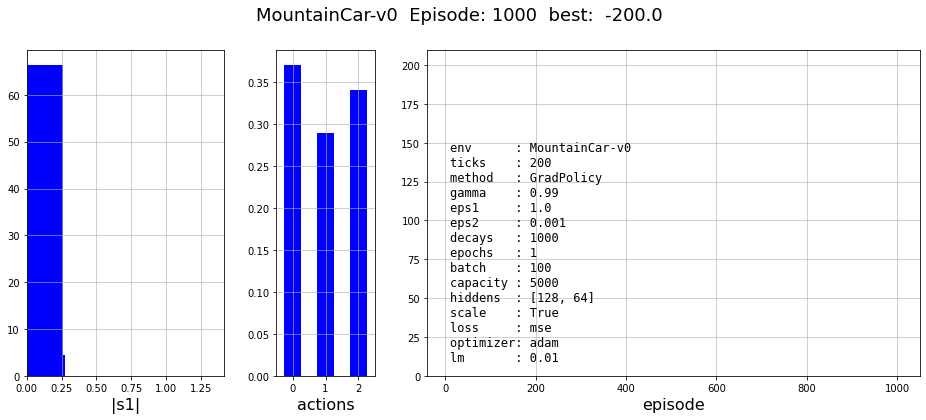

  1100 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  18s
  1200 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s
  1300 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s
  1400 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  16s
  1500 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s
  1600 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  16s
  1700 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s
  1800 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s
  1900 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  18s
  2000 rew: -200.0 ± 0.0, best:-200.00, ticks:200, eps:0.000,  loss:  0.000,  17s


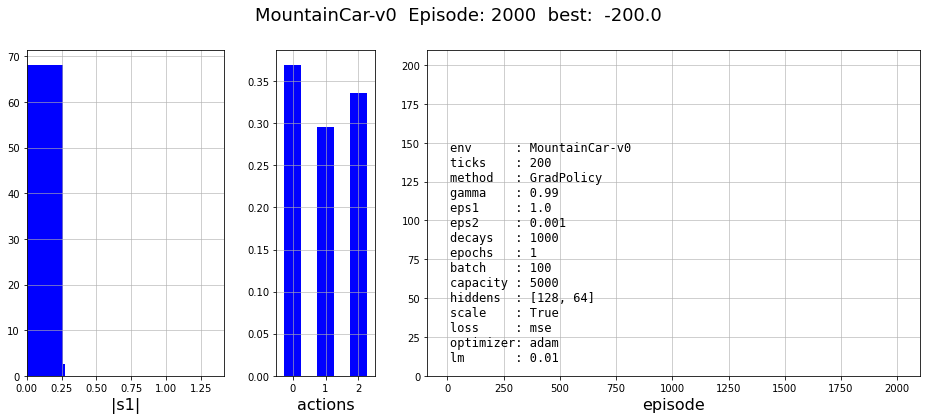

In [8]:
env_name = "MountainCar-v0"    # (nS=4, nA=2)
ml = GradientPolicy( gym.make(env_name) )

ml.params = {
    'env'      : env_name,
    'ticks'    : 200,      
    'method'   : "GradPolicy",# kind of the method (GradPolicy)     
    'gamma'    : 0.99,           # discount factor
    'eps1'     : 1.0,         # initial value epsilon
    'eps2'     : 0.001,       # final value   epsilon
    'decays'   : 1000,        # number of episodes to decay eps1 - > eps2   
    'epochs'   : 1,
    'batch'    : 100,         # batch size for training
    'capacity' : 5000,        # memory size    
    'hiddens'  : [128,64],    # hidden layers
    'scale'    : True,       # scale or not observe to [-1...1]
    'loss'     : 'mse',       # loss function (mse, huber)
    'optimizer': 'adam',      # optimizer (sgd, adam)
    'lm'       : 0.01,        # learning rate           
}

ml.init()
ml.learn(episodes=2000,  rews_range = [0, 210])

In [13]:
t = torch.tensor([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])
a = torch.tensor([[0], [2], [1]])
t.gather(1, a)

tensor([[1],
        [6],
        [8]])

In [28]:
bins = (11, 11)                      # число интервалов по каждой оси
low  = np.array([-1.2, -0.07])       # минимальные значения наблюдения
high = np.array([ 0.6,  0.07])       # минимальные значения наблюдения
bin  = (high-low)/bins               # ширины интервалов

def index(state):                    # вещественный state в пару индексов
    indx = ((state - low) / bin).clip(np.zeros_like(low), np.array(bins)-1)
    return tuple( indx.astype(int) )

index(np.array([-1,0.05]))

(1, 9)